## 学習アルゴリズムの実装

これまでに登場した損失関数、ミニバッチ、勾配、勾配降下法のキーワードを復習するため学習と手順を確認する。

<dl>
    <dt>前提</dt>
    <dd>ニューラルネットワークの重みとバイアスの最適値を求めることを学習と呼ぶ。学習には訓練データが必要。</dd>
    <dt>ステップ1 ミニバッチ</dt>
    <dd>訓練データが大量にある場合すべてのデータで損失関数を求めることは現実的ではないので、訓練データから一部のデータを取り出す。そのデータをミニバッチと呼ぶ。</dd>
    <dt>ステップ2 勾配の算出</dt>
    <dd>ミニバッチを入力としたニューラルネットワークで各重みパラメータの勾配を計算する。</dd>
    <dt>ステップ3 パラメータの更新</dt>
    <dd>勾配が損失関数を減らす方向を示しているので、そちらに重みパラメータを学習量ぶん更新する。</dd>
    <dt>ステップ4 繰り返す</dt>
    <dd>ステップ1〜3を繰り返す。</dd>
</dl>

この方法は無作為に取得したミニバッチを使うことから確率的勾配降下法(stochactic gradient descent)と呼ばれる。
ディープラーニングのフレームワークではこれの頭文字を取ってSGDという名前で実装されるのが一般的。

### 2層のニューラルネットワークのクラス

2層のニューラルネットワーク（隠れ層が1層）でMNISTデータセットを使い手書き数字を学習するニューラルネットワークを実装する。
TwoLayerNetという一つのクラスとして実装する。

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [2]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
p = net.params
p['W1'].shape

(784, 100)

In [3]:
p['b1'].shape

(100,)

In [4]:
p['W2'].shape

(100, 10)

In [5]:
p['b2'].shape

(10,)

In [6]:
x, t = np.random.rand(100, 784), np.random.rand(100, 10) # ダミーの入力データ、正解ラベル（100枚分）
x.shape, t.shape

((100, 784), (100, 10))

In [7]:
grads = net.numerical_gradient(x, t)
grads['W1'].shape

(784, 100)

### ミニバッチ学習の実装

教師データから無作為に一部のデータを取り出して、勾配法によりパラメータを更新する。

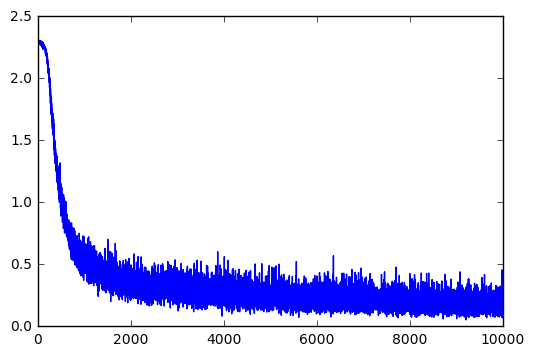

In [10]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
# グラフの描画
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.show()

### テストデータで評価

学習を繰り返すことで精度が上がり（損失関数の値が減少する）、パラメータが最適化する様子がわかったが、これはあくまでも訓練データに対するものであり、実際に汎用的に精度が出ているかどうかはわからない。
過学習が起きていないかの確認として、1エポックごとに訓練データとテストデータでの認識精度を記録する。

> エポック(epoch)は単位を示し、1エポックは訓練データをすべて使い切ったことを示す。10000個の訓練データに対し100個のミニバッチで学習する場合、100回のSGDを繰り返したら1エポックになる。

train acc, test acc | 0.0987166666667, 0.098
train acc, test acc | 0.79735, 0.8008
train acc, test acc | 0.8795, 0.8828
train acc, test acc | 0.898866666667, 0.9024
train acc, test acc | 0.906883333333, 0.9077
train acc, test acc | 0.914916666667, 0.9164
train acc, test acc | 0.920016666667, 0.9215
train acc, test acc | 0.9252, 0.9262
train acc, test acc | 0.929, 0.9289
train acc, test acc | 0.931483333333, 0.9304
train acc, test acc | 0.934683333333, 0.9344
train acc, test acc | 0.937633333333, 0.9375
train acc, test acc | 0.939533333333, 0.9389
train acc, test acc | 0.941683333333, 0.9422
train acc, test acc | 0.943933333333, 0.9432
train acc, test acc | 0.946016666667, 0.9456
train acc, test acc | 0.947083333333, 0.947


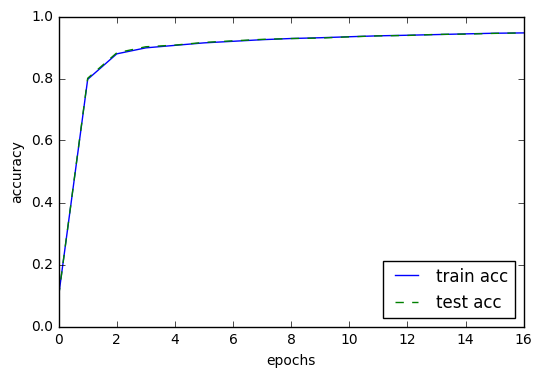

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()